# Time Series Model Testing Framework

## Objetivo
Este notebook implementa tests para determinar qué modelos de series de tiempo se pueden aplicar y seleccionar el que mejor se ajusta a los datos del dataset.

## Modelos evaluados:
- **ARIMA/SARIMA**: Modelos autorregresivos integrados de media móvil
- **Exponential Smoothing (Holt-Winters)**: Suavizado exponencial con tendencia y estacionalidad
- **Linear Regression**: Regresión lineal con tendencia temporal
- **Moving Averages**: Medias móviles simples y exponenciales
- **Prophet**: Modelo de Facebook para series de tiempo (si está disponible)

## Métricas de evaluación:
- **RMSE**: Root Mean Square Error (menor es mejor)
- **MAE**: Mean Absolute Error (menor es mejor)
- **MAPE**: Mean Absolute Percentage Error (menor es mejor)
- **R²**: Coeficiente de determinación (mayor es mejor)
- **AIC/BIC**: Criterios de información para selección de modelos (menor es mejor)

## 1. Instalación e importación de librerías

In [1]:
# Instalar librerías necesarias
%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels plotly

# Opcional: instalar Prophet para análisis más avanzado
# !pip install prophet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Importar el framework de testing
from time_series_model_testing import TimeSeriesModelTester

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Cargar y explorar los datos

In [12]:
# Crear instancia del tester
tester = TimeSeriesModelTester()

try:
    df = tester.load_olist_data(data_dir="/workspaces/TSCDIA-/proyecto_integrador/tp/data/")
    print("✅ Datos cargados exitosamente")
    
    # Mostrar información básica del dataset
    print(f"\n📊 Información del dataset:")
    print(f"- Observaciones: {len(df)}")
    print(f"- Período: {df.index.min()} a {df.index.max()}")
    print(f"- Columnas: {list(df.columns)}")
    
    # Mostrar primeras filas
    display(df.head())
    
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    print("Asegúrese de que los archivos CSV estén en 'proyecto_integrador/tp/data/'")

Cargando datos de Olist...


Datos cargados: 612 observaciones diarias
Período: 2016-09-15 00:00:00 a 2018-08-29 00:00:00
✅ Datos cargados exitosamente

📊 Información del dataset:
- Observaciones: 612
- Período: 2016-09-15 00:00:00 a 2018-08-29 00:00:00
- Columnas: ['orders_count', 'revenue']


,orders_count,revenue
date,,
2016-09-15,1,0.00
2016-10-03,7,559.53
2016-10-04,54,9821.42
2016-10-05,35,7209.50
2016-10-06,41,6733.52


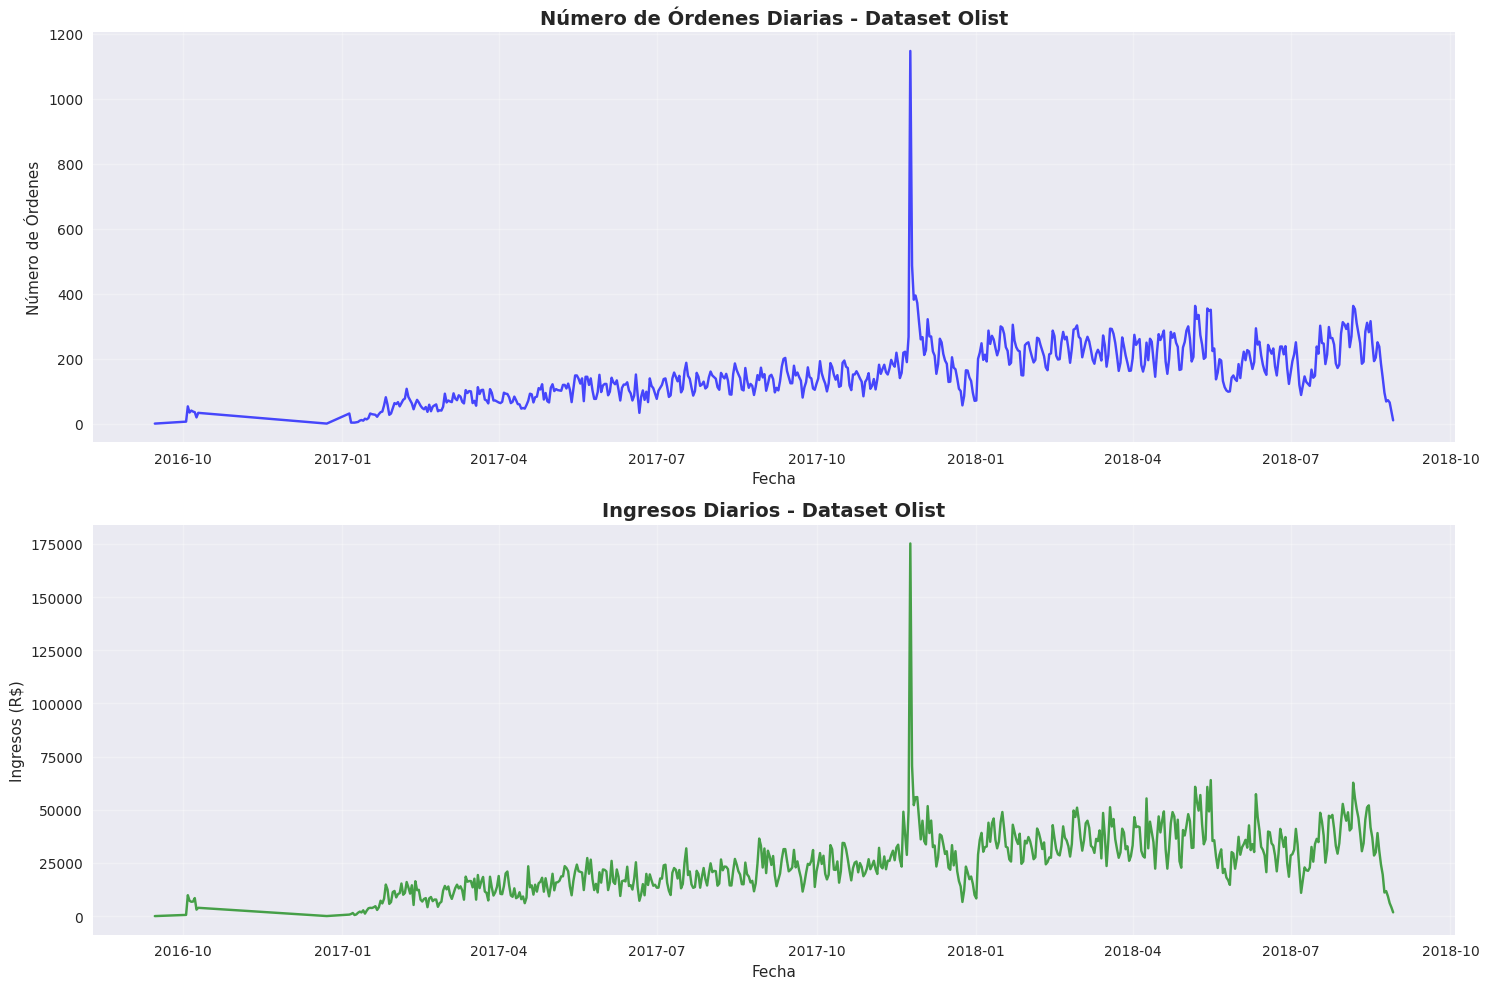


📈 Estadísticas descriptivas:


,orders_count,revenue
count,612.000000,612.000000
mean,157.643791,25200.100931
std,89.507146,14372.579303
min,1.000000,0.000000
25%,97.750000,14813.167500
50%,145.500000,23277.185000
75%,213.250000,33619.095000
max,1147.000000,175250.940000


In [ ]:
# Visualizar la serie de tiempo
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico de número de órdenes diarias
axes[0].plot(df.index, df['orders_count'], color='blue', alpha=0.7)
axes[0].set_title('Número de Órdenes Diarias - Dataset Olist', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Número de Órdenes')
axes[0].grid(True, alpha=0.3)

# Gráfico de ingresos diarios (si está disponible)
if 'revenue' in df.columns:
    axes[1].plot(df.index, df['revenue'], color='green', alpha=0.7)
    axes[1].set_title('Ingresos Diarios - Dataset Olist', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Fecha')
    axes[1].set_ylabel('Ingresos (R$)')
    axes[1].grid(True, alpha=0.3)
else:
    # Mostrar distribución de órdenes por día de la semana
    df_copy = df.copy()
    df_copy['day_of_week'] = df_copy.index.day_name() # type: ignore
    weekly_pattern = df_copy.groupby('day_of_week')['orders_count'].mean()
    
    # Reordenar días de la semana
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_pattern = weekly_pattern.reindex(days_order)
    
    axes[1].bar(weekly_pattern.index, weekly_pattern.values, color='orange', alpha=0.7)
    axes[1].set_title('Patrón Semanal Promedio de Órdenes', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Día de la Semana')
    axes[1].set_ylabel('Promedio de Órdenes')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\n📈 Estadísticas descriptivas:")
display(df.describe())

## 3. Preparar datos para análisis de series de tiempo

Serie de tiempo preparada: 612 observaciones
Datos divididos: 489 entrenamiento, 123 prueba


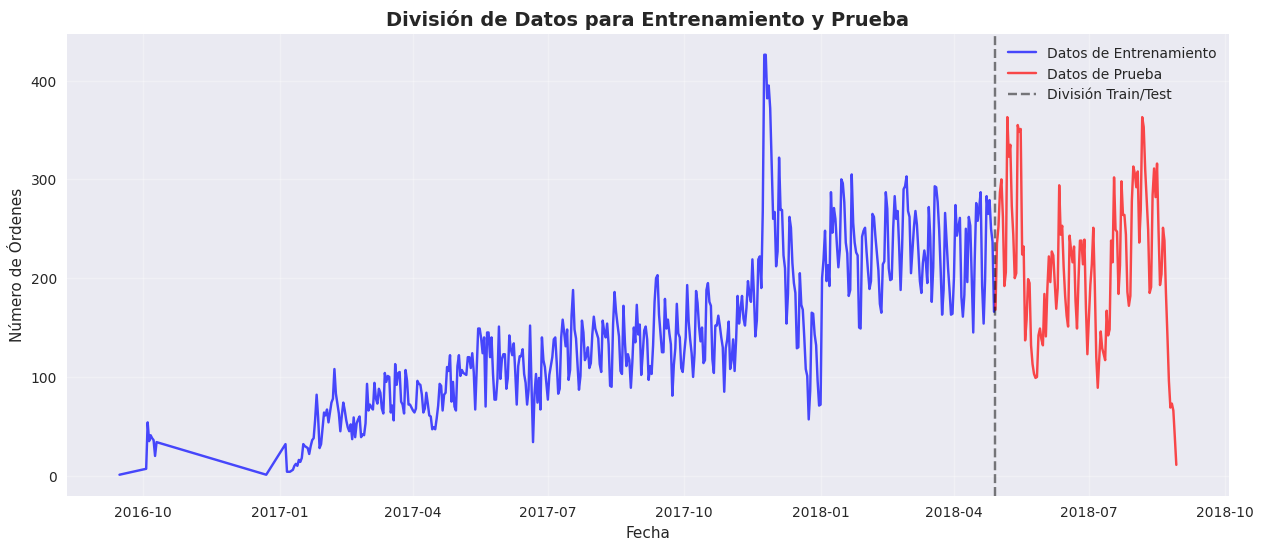

✅ Datos preparados:
- Entrenamiento: 489 observaciones
- Prueba: 123 observaciones


In [ ]:
# Preparar serie de tiempo usando número de órdenes
ts = tester.prepare_time_series(df, 'orders_count')

# Dividir en datos de entrenamiento y prueba
train_data, test_data = tester.split_data(test_size=0.2)

# Visualizar división de datos
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data.values, label='Datos de Entrenamiento', color='blue', alpha=0.7) # type: ignore
plt.plot(test_data.index, test_data.values, label='Datos de Prueba', color='red', alpha=0.7) # type: ignore
plt.axvline(x=test_data.index[0], color='black', linestyle='--', alpha=0.5, label='División Train/Test')
plt.title('División de Datos para Entrenamiento y Prueba', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Número de Órdenes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"✅ Datos preparados:")
print(f"- Entrenamiento: {len(train_data)} observaciones")
print(f"- Prueba: {len(test_data)} observaciones")

## 4. Ejecutar tests de todos los modelos

Esta celda ejecutará automáticamente todas las pruebas de modelos disponibles:

In [15]:
# Ejecutar todas las pruebas de modelos
print("🚀 Iniciando pruebas de modelos de series de tiempo...")
print("Esto puede tomar algunos minutos...")

results = tester.run_all_tests(seasonal_period=7)  # 7 días para estacionalidad semanal

print("\n✅ Pruebas completadas")

🚀 Iniciando pruebas de modelos de series de tiempo...
Esto puede tomar algunos minutos...
INICIANDO PRUEBAS DE MODELOS DE SERIES DE TIEMPO
Probando modelos ARIMA...


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

Probando modelo SARIMA...


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Probando Exponential Smoothing...


/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
19:01:23 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing


Probando Linear Regression...
Probando Moving Averages...
Probando Prophet...

✅ Pruebas completadas


## 5. Análisis de resultados y comparación de modelos

In [16]:
# Crear tabla comparativa de métricas
comparison_df = tester.create_comparison_table()

print("📊 TABLA COMPARATIVA DE MODELOS:")
print("=" * 50)
if not comparison_df.empty:
    # Mostrar tabla con formato mejorado
    display(comparison_df.style.format({
        'RMSE': '{:.4f}',
        'MAE': '{:.4f}',
        'MAPE': '{:.2f}%',
        'R²': '{:.4f}',
        'AIC': '{:.2f}',
        'BIC': '{:.2f}'
    }).background_gradient(subset=['RMSE', 'MAE', 'MAPE'], cmap='RdYlGn_r')
              .background_gradient(subset=['R²'], cmap='RdYlGn'))
else:
    print("❌ No se pudieron generar comparaciones")

📊 TABLA COMPARATIVA DE MODELOS:


,RMSE,MAE,MAPE,R²,Model,AIC,BIC
9,73.0245,58.8106,50.00%,-0.0014,EMA_0.5,nan,nan
8,74.2171,59.8336,54.42%,-0.0344,EMA_0.3,nan,nan
6,74.4250,59.9859,54.75%,-0.0402,SMA_30,nan,nan
7,75.6995,60.9036,56.51%,-0.0761,EMA_0.1,nan,nan
5,78.4681,62.8467,59.50%,-0.1563,SMA_14,nan,nan
4,79.0593,63.3589,60.10%,-0.1738,SMA_7,nan,nan
1,84.9238,68.8374,45.36%,-0.3543,"SARIMA(1,1,1)(1,1,1,7)",4482.18,4503.06
2,84.9238,68.8374,45.36%,-0.3543,"Exp_Smoothing_{'trend': 'mul', 'seasonal': 'mul', 'seasonal_periods': 7}",3178.57,nan
0,84.9238,68.8374,45.36%,-0.3543,"ARIMA(2, 1, 3)",4643.15,4668.29
10,97.2065,77.7577,77.05%,-0.7744,Prophet,nan,nan


In [17]:
# Identificar el mejor modelo
best_model, best_metrics = tester.find_best_model()

if best_model:
    print(f"\n🏆 MEJOR MODELO IDENTIFICADO: {best_model}")
    print("=" * 50)
    
    print("📈 Métricas del mejor modelo:")
    for metric, value in best_metrics.items():
        if metric != 'Model' and isinstance(value, (int, float)):
            if metric == 'MAPE':
                print(f"  {metric}: {value:.2f}%")
            else:
                print(f"  {metric}: {value:.4f}")
    
    # Interpretación de métricas
    print("\n📝 Interpretación:")
    if best_metrics['R²'] > 0.7:
        print("  ✅ Excelente ajuste del modelo (R² > 0.7)")
    elif best_metrics['R²'] > 0.5:
        print("  ✅ Buen ajuste del modelo (R² > 0.5)")
    elif best_metrics['R²'] > 0.3:
        print("  ⚠️ Ajuste moderado del modelo (R² > 0.3)")
    else:
        print("  ⚠️ Ajuste limitado del modelo (R² ≤ 0.3)")
    
    if best_metrics['MAPE'] < 10:
        print("  ✅ Error porcentual muy bajo (MAPE < 10%)")
    elif best_metrics['MAPE'] < 20:
        print("  ✅ Error porcentual bajo (MAPE < 20%)")
    elif best_metrics['MAPE'] < 50:
        print("  ⚠️ Error porcentual moderado (MAPE < 50%)")
    else:
        print("  ❌ Error porcentual alto (MAPE ≥ 50%)")

else:
    print("❌ No se pudo identificar el mejor modelo")


🏆 MEJOR MODELO IDENTIFICADO: EMA_0.5
📈 Métricas del mejor modelo:
  RMSE: 73.0245
  MAE: 58.8106
  MAPE: 50.00%
  R²: -0.0014
  AIC: nan
  BIC: nan

📝 Interpretación:
  ⚠️ Ajuste limitado del modelo (R² ≤ 0.3)
  ❌ Error porcentual alto (MAPE ≥ 50%)


## 6. Visualización de resultados

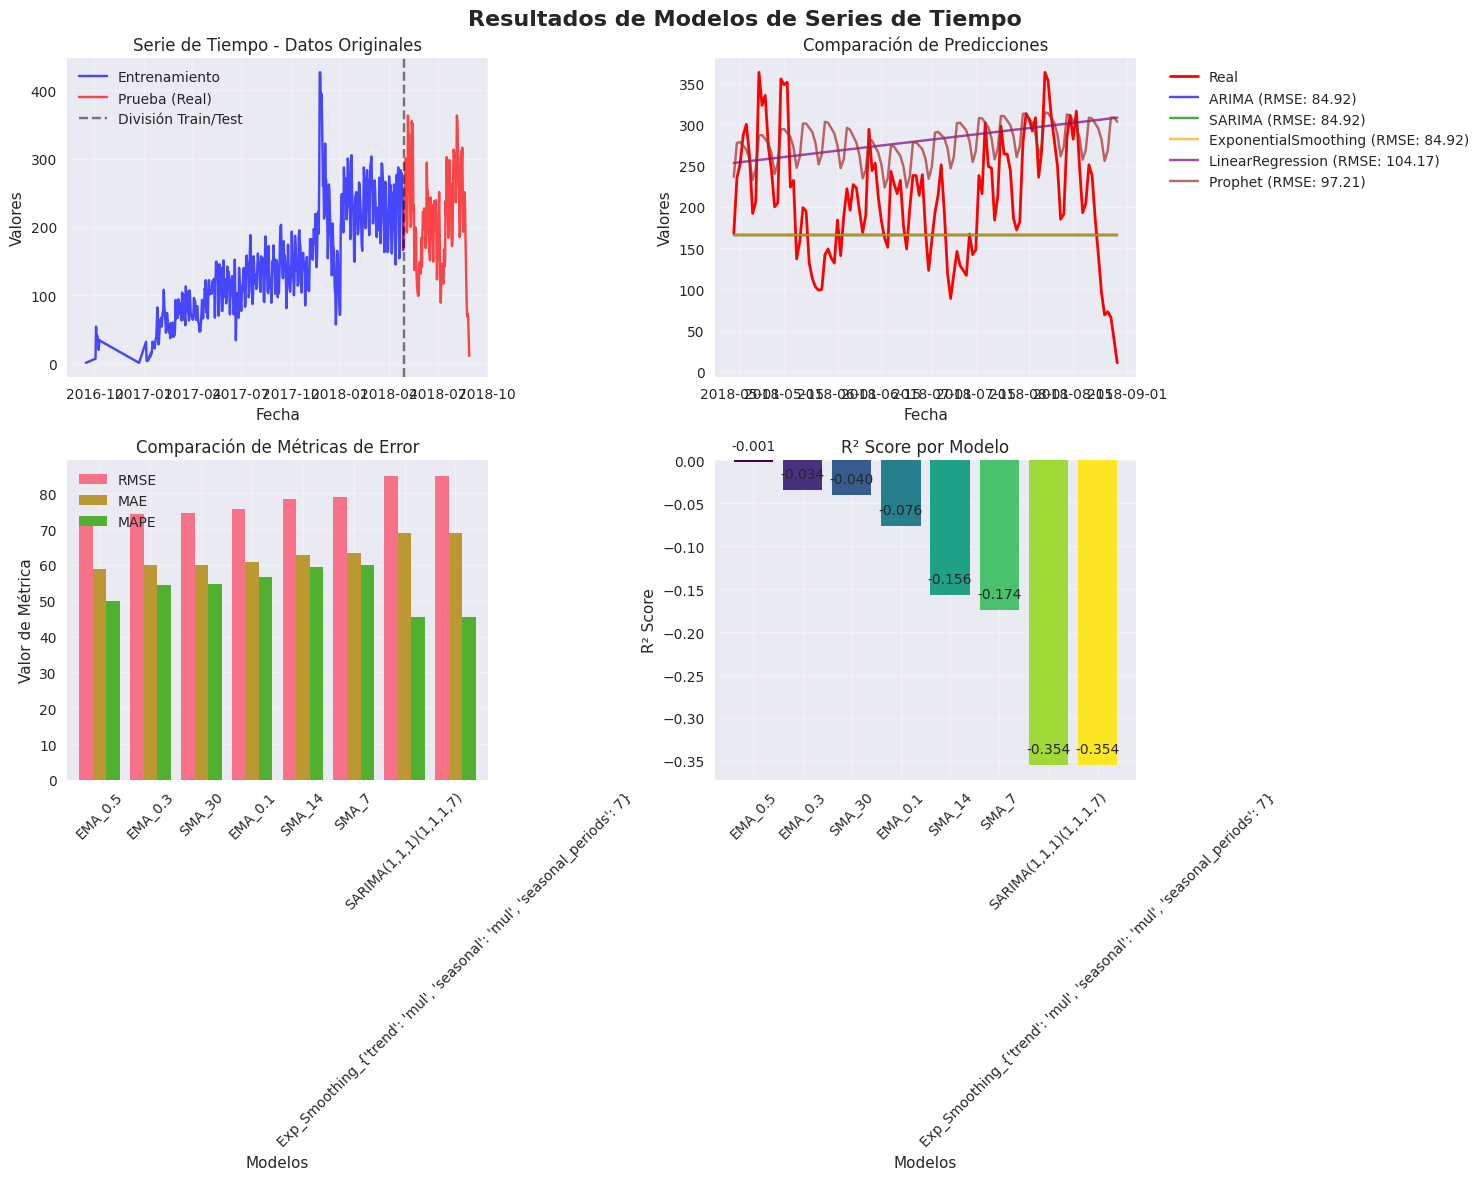


📊 Gráficas generadas exitosamente


In [18]:
# Generar visualizaciones completas
tester.plot_results()

print("\n📊 Gráficas generadas exitosamente")

## 7. Reporte detallado y recomendaciones

In [19]:
# Generar reporte completo
report = tester.generate_report()

# Mostrar reporte en el notebook
print("📄 REPORTE COMPLETO:")
print("=" * 80)
print(report)

📄 REPORTE COMPLETO:
REPORTE DE EVALUACIÓN DE MODELOS DE SERIES DE TIEMPO
Fecha de análisis: 2025-09-18 19:01:24

INFORMACIÓN DEL DATASET:
----------------------------------------
Total de observaciones: 612
Período de entrenamiento: 2016-09-15 00:00:00 a 2018-04-28 00:00:00 (489 observaciones)
Período de prueba: 2018-04-29 00:00:00 a 2018-08-29 00:00:00 (123 observaciones)
Valor promedio: 156.37
Desviación estándar: 80.41

MEJOR MODELO IDENTIFICADO:
----------------------------------------
Modelo: EMA_0.5
Métricas del mejor modelo:
  RMSE: 73.0245
  MAE: 58.8106
  MAPE: 50.0021
  R²: -0.0014
  AIC: nan
  BIC: nan

COMPARACIÓN COMPLETA DE MODELOS:
----------------------------------------
    RMSE     MAE    MAPE      R²                                                                    Model       AIC       BIC
 73.0245 58.8106 50.0021 -0.0014                                                                  EMA_0.5       NaN       NaN
 74.2171 59.8336 54.4168 -0.0344                    

## 8. Análisis específico del mejor modelo

Vamos a analizar en detalle el mejor modelo identificado:

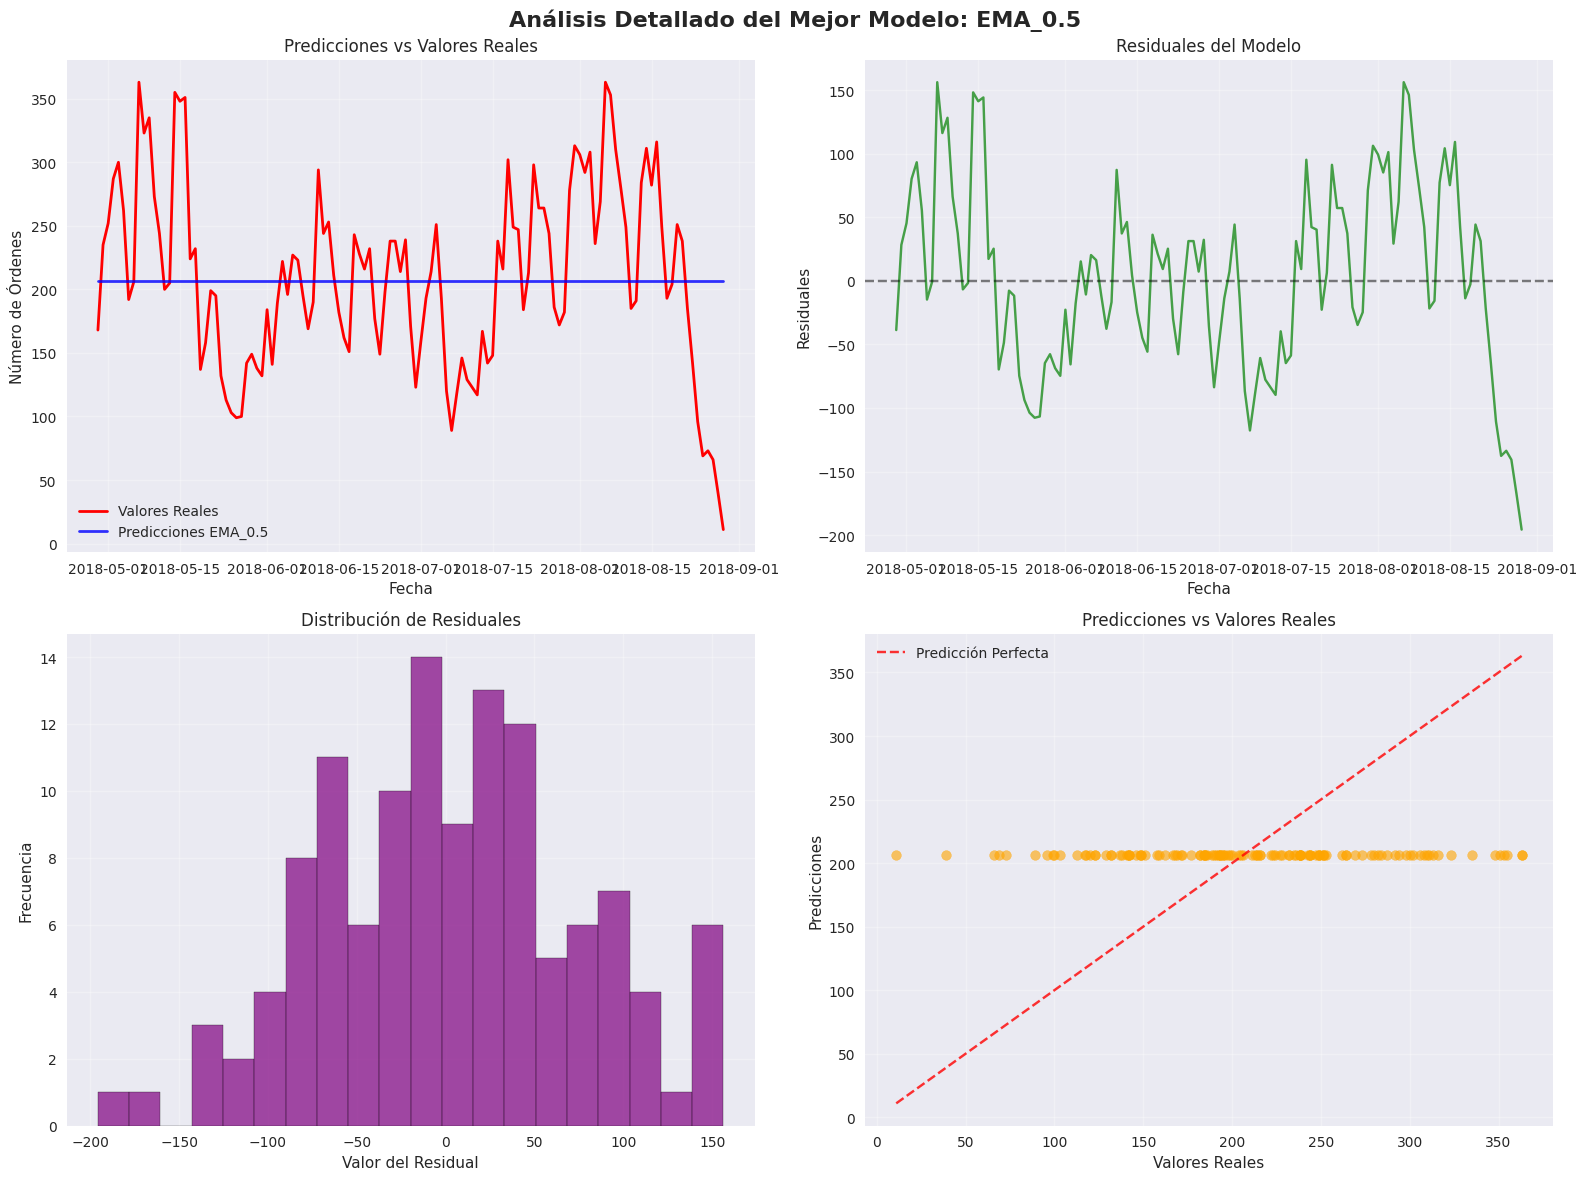


📊 Análisis de Residuales para EMA_0.5:
  Media de residuales: 2.7334
  Desviación estándar: 72.9733
  Residual mínimo: -195.7057
  Residual máximo: 156.2943


In [20]:
if best_model and tester.results:
    # Encontrar el resultado del mejor modelo
    best_result = None
    
    for model_type, result in tester.results.items():
        if 'error' in result:
            continue
            
        if model_type == 'MovingAverages':
            for variant, variant_result in result.items():
                if 'metrics' in variant_result and variant_result['metrics']['Model'] == best_model:
                    best_result = variant_result
                    break
        else:
            if 'metrics' in result and result['metrics']['Model'] == best_model:
                best_result = result
                break
    
    if best_result and 'forecast' in best_result:
        # Visualización detallada del mejor modelo
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Análisis Detallado del Mejor Modelo: {best_model}', fontsize=16, fontweight='bold')
        
        # 1. Predicciones vs valores reales
        ax1 = axes[0, 0]
        ax1.plot(test_data.index, test_data.values, label='Valores Reales', color='red', linewidth=2)
        ax1.plot(best_result['forecast'].index, best_result['forecast'].values, 
                label=f'Predicciones {best_model}', color='blue', linewidth=2, alpha=0.8)
        ax1.set_title('Predicciones vs Valores Reales')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Número de Órdenes')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Residuales
        ax2 = axes[0, 1]
        residuals = test_data.values - best_result['forecast'].values
        ax2.plot(test_data.index, residuals, color='green', alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title('Residuales del Modelo')
        ax2.set_xlabel('Fecha')
        ax2.set_ylabel('Residuales')
        ax2.grid(True, alpha=0.3)
        
        # 3. Distribución de residuales
        ax3 = axes[1, 0]
        ax3.hist(residuals, bins=20, alpha=0.7, color='purple', edgecolor='black')
        ax3.set_title('Distribución de Residuales')
        ax3.set_xlabel('Valor del Residual')
        ax3.set_ylabel('Frecuencia')
        ax3.grid(True, alpha=0.3)
        
        # 4. Scatter plot: predicciones vs reales
        ax4 = axes[1, 1]
        ax4.scatter(test_data.values, best_result['forecast'].values, alpha=0.6, color='orange')
        # Línea de referencia perfecta
        min_val = min(test_data.values.min(), best_result['forecast'].values.min())
        max_val = max(test_data.values.max(), best_result['forecast'].values.max())
        ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Predicción Perfecta')
        ax4.set_title('Predicciones vs Valores Reales')
        ax4.set_xlabel('Valores Reales')
        ax4.set_ylabel('Predicciones')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Estadísticas de residuales
        print(f"\n📊 Análisis de Residuales para {best_model}:")
        print(f"  Media de residuales: {np.mean(residuals):.4f}")
        print(f"  Desviación estándar: {np.std(residuals):.4f}")
        print(f"  Residual mínimo: {np.min(residuals):.4f}")
        print(f"  Residual máximo: {np.max(residuals):.4f}")
        
    else:
        print("❌ No se pudieron obtener las predicciones del mejor modelo")
else:
    print("❌ No se pudo realizar el análisis detallado")

## 9. Conclusiones y Recomendaciones Finales

In [21]:
print("🎯 CONCLUSIONES Y RECOMENDACIONES FINALES:")
print("=" * 60)

if best_model and comparison_df is not None and not comparison_df.empty:
    
    # Análisis del mejor modelo
    print(f"\n1. 🏆 MEJOR MODELO: {best_model}")
    print(f"   - RMSE: {best_metrics['RMSE']:.4f}")
    print(f"   - MAPE: {best_metrics['MAPE']:.2f}%")
    print(f"   - R²: {best_metrics['R²']:.4f}")
    
    # Recomendaciones específicas por tipo de modelo
    print("\n2. 📝 RECOMENDACIONES ESPECÍFICAS:")
    
    if 'ARIMA' in best_model:
        print("   ✅ ARIMA es efectivo para capturar patrones autorregresivos")
        print("   📌 Monitorear residuales para validar supuestos del modelo")
        print("   📌 Re-evaluar parámetros (p,d,q) con nuevos datos")
    
    elif 'SARIMA' in best_model:
        print("   ✅ SARIMA captura bien la estacionalidad en los datos")
        print("   📌 Ajustar parámetros estacionales si cambian los patrones")
        print("   📌 Considerar eventos especiales (feriados, promociones)")
    
    elif 'Prophet' in best_model:
        print("   ✅ Prophet es robusto para múltiples estacionalidades")
        print("   📌 Incluir efectos de días festivos y eventos especiales")
        print("   📌 Ajustar hiperparámetros de flexibilidad de tendencia")
    
    elif 'Exp_Smoothing' in best_model:
        print("   ✅ Suavizado exponencial bueno para tendencias y estacionalidad")
        print("   📌 Actualizar parámetros regularmente con nuevos datos")
        print("   📌 Monitorear cambios en patrones de tendencia")
    
    elif 'MA' in best_model or 'EMA' in best_model:
        print("   ✅ Medias móviles son simples y efectivas para datos estables")
        print("   📌 Ajustar ventana temporal según volatilidad de los datos")
        print("   📌 Combinar con otros métodos para mejor precisión")
    
    elif 'Linear' in best_model:
        print("   ✅ Regresión lineal captura tendencias simples")
        print("   📌 Considerar agregar variables explicativas")
        print("   📌 Evaluar necesidad de transformaciones no lineales")
    
    # Recomendaciones generales
    print("\n3. 🎯 RECOMENDACIONES GENERALES:")
    print("   📈 Validar predicciones con datos reales periódicamente")
    print("   🔄 Re-entrenar modelos mensualmente con nuevos datos")
    print("   📊 Monitorear métricas de desempeño continuamente")
    print("   🎪 Considerar eventos externos que afecten las ventas")
    print("   🔍 Analizar residuales para detectar patrones no capturados")
    
    # Análisis de rendimiento relativo
    print("\n4. 📊 ANÁLISIS COMPARATIVO:")
    top_3 = comparison_df.head(3)
    print("   Top 3 modelos por RMSE:")
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"   {i}. {row['Model']}: RMSE = {row['RMSE']:.4f}, MAPE = {row['MAPE']:.2f}%")
    
    # Sugerencias de mejora
    print("\n5. 🚀 OPORTUNIDADES DE MEJORA:")
    
    if best_metrics['R²'] < 0.5:
        print("   📌 R² bajo sugiere agregar variables explicativas")
        print("   📌 Considerar factores externos (marketing, estacionalidad, competencia)")
    
    if best_metrics['MAPE'] > 30:
        print("   📌 MAPE alto sugiere volatilidad en los datos")
        print("   📌 Considerar modelos ensemble o técnicas de regularización")
    
    print("   📌 Explorar combinación de múltiples modelos (ensemble)")
    print("   📌 Incluir variables exógenas (precios, promociones, clima)")
    print("   📌 Analizar diferentes horizontes de predicción")
    
else:
    print("❌ No se pudieron generar conclusiones debido a errores en el análisis")

print("\n" + "=" * 60)
print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
print("📁 Archivos generados:")
print("   - time_series_analysis_results.png (visualizaciones)")
print("   - time_series_analysis_report.txt (reporte completo)")
print("=" * 60)

🎯 CONCLUSIONES Y RECOMENDACIONES FINALES:

1. 🏆 MEJOR MODELO: EMA_0.5
   - RMSE: 73.0245
   - MAPE: 50.00%
   - R²: -0.0014

2. 📝 RECOMENDACIONES ESPECÍFICAS:
   ✅ Medias móviles son simples y efectivas para datos estables
   📌 Ajustar ventana temporal según volatilidad de los datos
   📌 Combinar con otros métodos para mejor precisión

3. 🎯 RECOMENDACIONES GENERALES:
   📈 Validar predicciones con datos reales periódicamente
   🔄 Re-entrenar modelos mensualmente con nuevos datos
   📊 Monitorear métricas de desempeño continuamente
   🎪 Considerar eventos externos que afecten las ventas
   🔍 Analizar residuales para detectar patrones no capturados

4. 📊 ANÁLISIS COMPARATIVO:
   Top 3 modelos por RMSE:
   1. EMA_0.5: RMSE = 73.0245, MAPE = 50.00%
   2. EMA_0.3: RMSE = 74.2171, MAPE = 54.42%
   3. SMA_30: RMSE = 74.4250, MAPE = 54.75%

5. 🚀 OPORTUNIDADES DE MEJORA:
   📌 R² bajo sugiere agregar variables explicativas
   📌 Considerar factores externos (marketing, estacionalidad, competencia)


## 10. Próximos pasos (Opcional)

Para continuar mejorando el análisis, considere:

In [22]:
print("🔮 PRÓXIMOS PASOS SUGERIDOS:")
print("=" * 40)
print("\n1. 📊 Análisis adicional:")
print("   - Probar diferentes horizontes de predicción (1, 7, 30 días)")
print("   - Incluir variables exógenas (promociones, días festivos)")
print("   - Analizar estacionalidad por categorías de productos")

print("\n2. 🔧 Mejoras técnicas:")
print("   - Implementar validación cruzada temporal")
print("   - Probar modelos de machine learning (XGBoost, LSTM)")
print("   - Desarrollar modelos ensemble")

print("\n3. 🎯 Implementación:")
print("   - Crear pipeline automatizado de predicciones")
print("   - Implementar monitoreo de drift en los datos")
print("   - Desarrollar dashboard de seguimiento")

print("\n4. 📈 Validación continua:")
print("   - Configurar alertas de desempeño")
print("   - Establecer métricas de negocio")
print("   - Planificar re-entrenamiento automático")

🔮 PRÓXIMOS PASOS SUGERIDOS:

1. 📊 Análisis adicional:
   - Probar diferentes horizontes de predicción (1, 7, 30 días)
   - Incluir variables exógenas (promociones, días festivos)
   - Analizar estacionalidad por categorías de productos

2. 🔧 Mejoras técnicas:
   - Implementar validación cruzada temporal
   - Probar modelos de machine learning (XGBoost, LSTM)
   - Desarrollar modelos ensemble

3. 🎯 Implementación:
   - Crear pipeline automatizado de predicciones
   - Implementar monitoreo de drift en los datos
   - Desarrollar dashboard de seguimiento

4. 📈 Validación continua:
   - Configurar alertas de desempeño
   - Establecer métricas de negocio
   - Planificar re-entrenamiento automático
